# Mit SIR Modell COVID-19 Simulieren

In [1]:
# get nice vector graphics in pdf export
from IPython.display import set_matplotlib_formats 
set_matplotlib_formats('pdf','svg')
# import Package 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist

## SIR Modell Aufbau mit Euler Verfahren 
Wir haben die SIR Modell mit Impfung ($V$)  
S steht für susceptible, I für infected, R für recovered und V für Geimpften. Die Zeitentwicklung wird durch folgende gekoppelte, gewöhnliche DGL beschrieben:
$$\begin{aligned}
    S'(t) &=-\frac{\beta(t)}{N} S(t) I(t)-\Gamma(t)+\delta V(t) \\
    I'(t) &=\frac{\beta(t)}{N} S(t) I(t)-\alpha I(t) \\
    R'(t) &=\alpha I(t) \\
    V'(t) &=\Gamma(t)-\delta V(t)
\end{aligned} $$ 
Hier $\Gamma(t)$ ist nach oben beschränkt durch $S(t)$ selbst. Wir nehmen an, dass $\gamma(t)$ Personen pro Zeit geimpft werden können. Dementsprechend muss:
\begin{equation}
    \Gamma(t)=min\{\gamma(t),S(t)\}
\end{equation}
Geimpfte können mit Rate $\delta$ wieder infiziert werden. $\delta$ ist zur Zeit weitestgehend unbekannt, aber von der Größenordnung von einigen inversen Monaten, sage wir 5 inverse Monate.  
Das Verhältnis von $R_0 = \beta/\alpha$ ist die Basisreproduktionszahl. Für SARS-CoV-2 ist $R_0 ≈ 2.9$, falls keine Maßnahmen getroffen werden, um die Pandemie einzudämmen. $\alpha$ ist ungefähr die inverse Zeit, die Infizierte ansteckend sind, also ca. 7 Tage.



In [2]:
def EulerStep(X, alpha, beta, Gamma, delta, N, dt):
    '''
    Mit Euler Verfahren fuer SIR Modell um nächste Zustand durch dt Zeit zu rechnen
    -X als Anfangszustand wobei:
        -X[0] ist S susceptible
        -X[1] ist I infected
        -X[2] ist R recovered
        -X[3] ist V vaccinated
    -alpha, beta, Gamma, delta, N siehen SIR Modell
    -dt als Schrittgrosse 
    '''
    Y = X
    Y[0]=X[0] + dt*(-beta*X[0]*X[1]/N - Gamma + delta*X[3]) # S
    Y[1]=X[1] + dt*(beta*X[0]*X[1]/N - alpha*X[1]) # I
    Y[2]=X[2] + dt*(alpha*X[1]) # R
    Y[3]=X[3] + dt*(Gamma - delta*X[3]) # V
    return Y

## Simulation für verschiedene $R_0$

In [3]:
N = int(83e6)
r0 = np.linspace(1,20,20)
alpha = 1/7
beta = alpha*r0
Gamma = 0
delta = 1/150
dt = 0.1
n = 3650
X = np.zeros((N,4))

#Anfangsbedingungen
X[0,0] = N-5000
X[0,1] = N-X[0,0]

def asymptote (X, alpha, beta, N, dt):
    while(X[1]>=1):
        X = EulerStep(X, alpha, beta, 0, 0, N, dt)
    return X[0]

remaining_S=np.zeros(20)
for i in range(0,20):
    remaining_S[i]=asymptote(X[0], alpha, beta[i], N, dt)
    #refresh Anfangsbedingungen
    X[0,0] = N-5000
    X[0,1] = N-X[0,0]


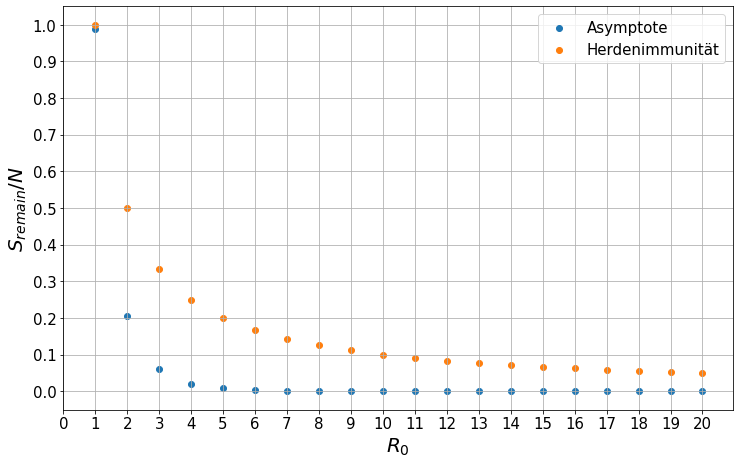

In [4]:
size=12
plt.figure(figsize=(size,size*0.618))
plt.scatter(r0,remaining_S/N,label="Asymptote")
plt.scatter(r0,1/r0,label="Herdenimmunität")
plt.ylabel("$S_{remain}/N$", fontsize=20)
plt.xlabel("$R_0$", fontsize=20)
plt.xticks(np.arange(0, 21),fontsize=15)
plt.yticks(np.arange(0,1.1,step=0.1),fontsize=15)
plt.legend(fontsize = 15)
plt.grid(True)
plt.show()

In [5]:
'''
neu definition über gamma und beta 
datei von https://www.worldometers.info/coronavirus/country/germany/#graph-cases-daily
'''
def gamma(t):
    if(t < 17):
        return(0.) # bis zum 17.1. 
    elif(t < 115):
        return(61000.) # bis zum 25.4. 
    else: 
        return(128000.)
def beta(t):
    if(t < 43):
        return(0.1209109) # bis zum 13.2. fallende Zahlen
    elif(t < 68):
        return(0.1485441) # bis zum 10.3. leicht steigende Zahlen 
    elif(t < 105):
        return(0.167162) # bis zum 16.4. steigende Zahlen
    elif(t < 117):
        return(0.1428571) # bis zum 28.4. konstante Zahlen
    else:
        return(0.1132363) # seitdem fallende Zahlen
    
#plot R_0 mit t
t = np.linspace(1,300,300)
r_0 = np.zeros(300)
for i in range(0,300):
    r_0[i]=beta(t[i])/alpha

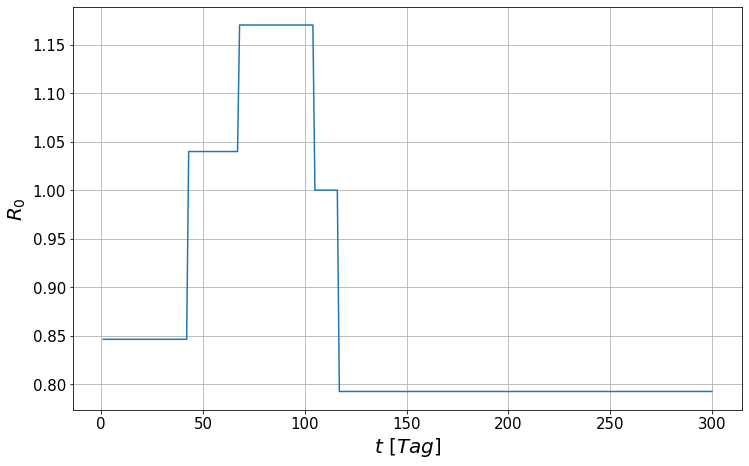

In [6]:

size=12
plt.figure(figsize=(size,size*0.618))
plt.plot(t,r_0)
plt.ylabel("$R_0$", fontsize=20)
plt.xlabel("$t\ [Tag]$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.legend(fontsize = 15)
plt.grid(True)
plt.show()

## Naive Simulieren

In [7]:
def naive_Simulieren():
    ## Anfangsbedingungen 
    N = int(83e6)
    alpha = 1/7
    Gamma = 0
    delta = 1/150
    dt = 0.1
    n = 3650
    X = np.zeros((N,4))
    X[0,1] = 130000 # infected
    X[0,2] = 1.7e6 # recovered
    X[0,0] = N-X[0,2]-X[0,1] # susceptible 
    X[0,3] = 0 # vaccinated
    
    # 
    for i in range(1,n):
        t = i*dt
        Gamma = min(gamma(t),X[i-1,0])
        X[i] = EulerStep(X[i-1,], alpha, beta(t), Gamma, delta, N, dt)
    return X

#plot X(I,R,V) mit t
t = np.linspace(0,365,3650)
X = naive_Simulieren()
"""
Hier der Skala des Skala für I,R,V ist konstante Für alle drei IRV Simulierung plot. 
Da I Skala bis 160,000 
   R Skala bis 4,000,000
   V Skala bis 18,000,000
Da kann mann besser die Ergibnisse vergleichen.
"""

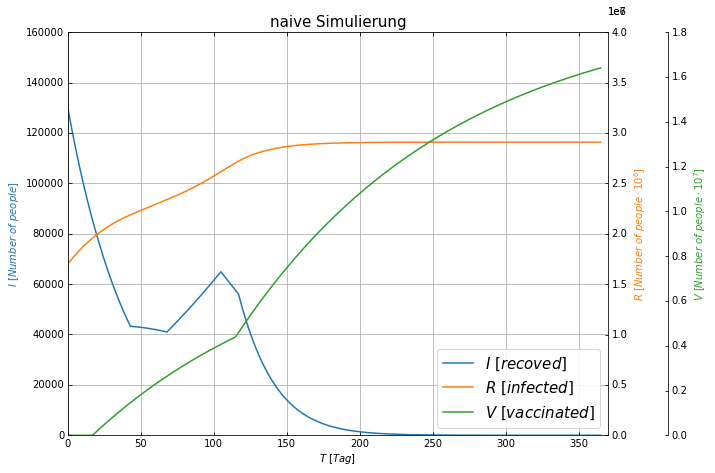

In [8]:
fig = plt.figure(figsize=(size,size*0.618))
host = host_subplot(111, axes_class=axisartist.Axes)
plt.subplots_adjust(right=0.75)
par1 = host.twinx()
par2 = host.twinx()
par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))
par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)
p1, = host.plot(t,X[:n,1],label="$I\ [recoved]$")
p2, = par1.plot(t,X[:n,2],label="$R\ [infected]$")
p3, = par2.plot(t,X[:n,3],label="$V\ [vaccinated]$")
host.set_xlim(0, 370)
host.set_ylim(-10, 16e4)
par1.set_ylim(0, 4e6)
par2.set_ylim(0, 1.8e7)
host.set_xlabel("$T\ [Tag]$",fontsize=15)
host.set_ylabel("$I\ [Number\ of\ people]$", fontsize=15)
par1.set_ylabel("$R\ [Number\ of\ people\cdot10^6]$",fontsize=15)
par2.set_ylabel("$V\ [Number\ of\ people\cdot10^7]$",fontsize=15)
host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())
host.grid(True)
host.legend(loc=4,fontsize = 15)
plt.title(label="naive Simulierung",fontsize=15)
plt.show()

## korrigieret Simulieren

In [9]:
def betaeff_Simulieren():
    ## Anfangsbedingungen 
    N = int(83e6)
    delta = 1/150
    dt = 0.1
    n = 3650
    X = np.zeros((N,4))
    X[0,1] = 130000 # infected
    X[0,2] = 1.7e6 # recovered
    X[0,0] = N-X[0,2]-X[0,1] # susceptible 
    X[0,3] = 0 # vaccinated
    
    for i in range(1,n):
        t = i*dt
        beta_eff= beta(t)*N/X[i-1,0]
        Gamma = min(gamma(t),X[i-1,0])
        X[i] = EulerStep(X[i-1,], alpha, beta_eff, Gamma, delta, N, dt)
    return X

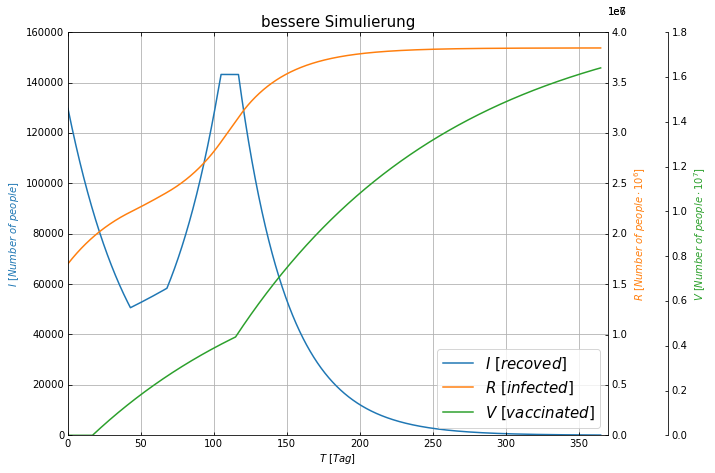

In [10]:
t = np.linspace(0,365,3650)
X = betaeff_Simulieren()
fig = plt.figure(figsize=(size,size*0.618))
host = host_subplot(111, axes_class=axisartist.Axes)
plt.subplots_adjust(right=0.75)
par1 = host.twinx()
par2 = host.twinx()
par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))
par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)
p1, = host.plot(t,X[:n,1],label="$I\ [recoved]$")
p2, = par1.plot(t,X[:n,2],label="$R\ [infected]$")
p3, = par2.plot(t,X[:n,3],label="$V\ [vaccinated]$")
host.set_xlim(0, 370)
host.set_ylim(-10, 16e4)
par1.set_ylim(0, 4e6)
par2.set_ylim(0, 1.8e7)
host.set_xlabel("$T\ [Tag]$",fontsize=15)
host.set_ylabel("$I\ [Number\ of\ people]$", fontsize=15)
par1.set_ylabel("$R\ [Number\ of\ people\cdot10^6]$",fontsize=15)
par2.set_ylabel("$V\ [Number\ of\ people\cdot10^7]$",fontsize=15)
host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())
host.grid(True)
host.legend(loc=4,fontsize = 15)
plt.title(label="bessere Simulierung",fontsize=15)
plt.show()

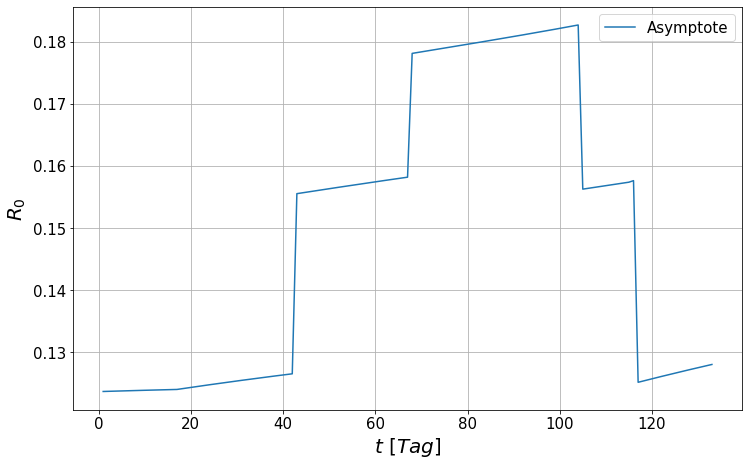

In [11]:
t = np.linspace(1,133,133)
R_0 = np.zeros(133)
for i in range(0,133):
    R_0[i]=beta(t[i])*N/X[int(10*t[i]-1),0]
size=12
plt.figure(figsize=(size,size*0.618))
plt.plot(t,R_0,label="Asymptote")
plt.xlabel("$t\ [Tag]$", fontsize=20)
plt.ylabel("$R_0$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize = 15)
plt.grid(True)
plt.show()

## Abhängig von Schrittgröße

In [12]:
def zeitenwicklung(dt):
    ## Anfangsbedingungen 
    N = int(83e6)
    alpha = 1/7
    delta = 1/150
    X = np.zeros((N,4))
    n =  int(133/dt)  
    X[0,1] = 130000 # infected
    X[0,2] = 1.7e6 # recovered
    X[0,0] = N-X[0,2]-X[0,1] # susceptible 
    X[0,3] = 0 # vaccinated
    
    for i in range(1,n):
        t = i*dt
        beta_eff= beta(t)*N/X[i-1,0]
        Gamma = min(gamma(t),X[i-1,0])
        X[i] = EulerStep(X[i-1], alpha, beta_eff, Gamma, delta, N, dt)
    return X[n-2,1]/7

def heutiges_I():
    schritte = dt*np.linspace(1,30,30)/2
    heutiges_I=np.zeros(30)
    for i in range(0,30):
        heutiges_I[i]=zeitenwicklung(schritte[i])
    return heutiges_I

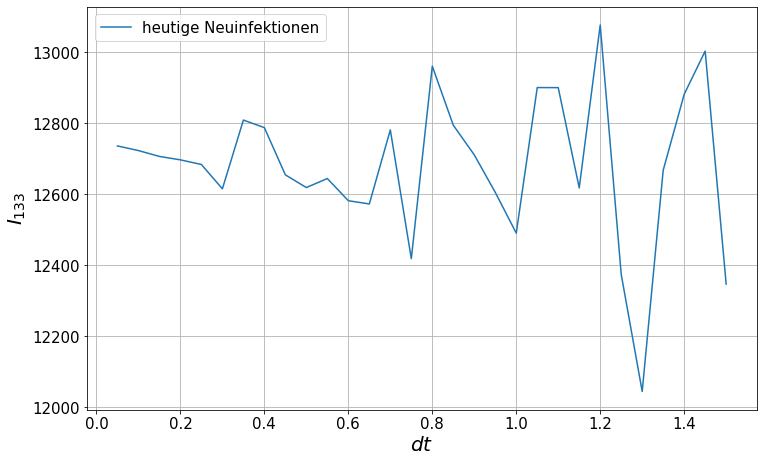

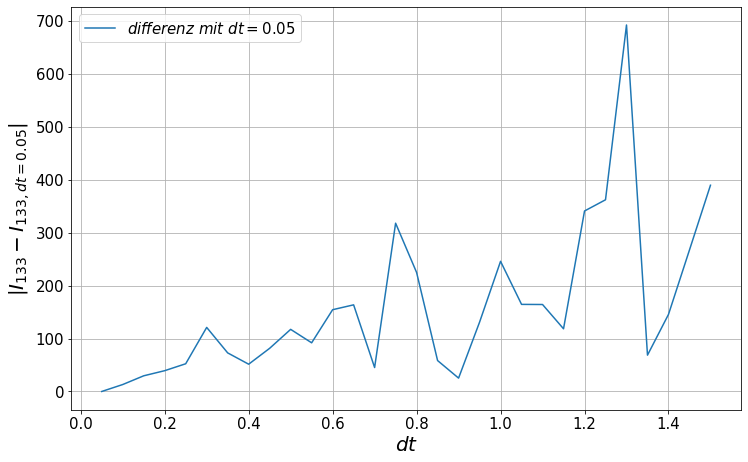

In [13]:
heutiges_I = heutiges_I()
schritte = dt*np.linspace(1,30,30)/2
size=12
plt.figure(figsize=(size,size*0.618))
plt.plot(schritte,heutiges_I,label="heutige Neuinfektionen")
plt.ylabel("$I_{133}$", fontsize=20)
plt.xlabel("$dt$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize = 15)
plt.grid(True)
plt.show()
plt.figure(figsize=(size,size*0.618))
plt.plot(schritte,abs(heutiges_I[0]-heutiges_I),label="$differenz\ mit\ dt=0.05$")
plt.ylabel("$|I_{133}-I_{133,dt=0.05}|$", fontsize=20)
plt.xlabel("$dt$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize = 15)
plt.grid(True)
plt.show()

## No COVID statiegie Situation 

In [14]:
def beta_ns(t,t0):
    if (t<16):
        return (0.1209109)## bis zum 13.2. fallende Zahlen 
    if(t0!=np.nan):
        if(t >= t0):
            return(1.2/7.) ## halten R0 bei 1.01 konstant }
    if(t >= 16):
        return(0.5/7.) ## harter lockdown 
    
def No_Covid_Strategie():
    ## Anfangsbedingungen 
    X = np.zeros((n,4))
    X[0,1] = 130000 # infected
    X[0,2] = 1.7e6 # recovered
    X[0,0] = N-X[0,2]-X[0,1] # susceptible X[1,4] = 0 # vaccinated
    t0 = np.nan

    for i in range(1,n):
        t = i*dt
        ## set t0 as soon as I < 10000 
        if(np.isnan(t0)):
            if(X[i-1,1] < 10000): 
                t0 =t 
        beta_eff = beta_ns(t, t0)
        ## saisonaler Effekt ab Mai
        if(t > 122): 
            beta_eff = beta_eff*0.8 
        Gamma = min(gamma(t), X[i-1, 0])
        X[i] = EulerStep(X[i-1], alpha, beta_eff, Gamma, delta, N, dt)
    return X

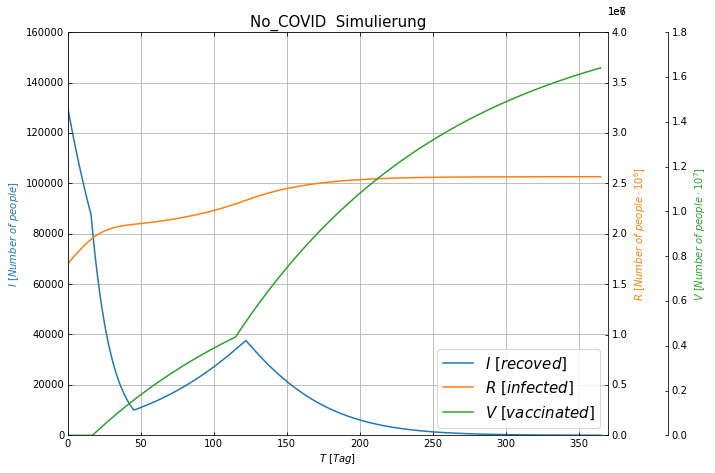

In [17]:
X2 = No_Covid_Strategie()
t = np.linspace(0,365,3650)
fig = plt.figure(figsize=(size,size*0.618))
host = host_subplot(111, axes_class=axisartist.Axes)
plt.subplots_adjust(right=0.75)
par1 = host.twinx()
par2 = host.twinx()
par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))
par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)
p1, = host.plot(t,X2[:n,1],label="$I\ [recoved]$")
p2, = par1.plot(t,X2[:n,2],label="$R\ [infected]$")
p3, = par2.plot(t,X2[:n,3],label="$V\ [vaccinated]$")
host.set_xlim(0, 370)
host.set_ylim(-10, 16e4)
par1.set_ylim(0, 4e6)
par2.set_ylim(0, 1.8e7)
host.set_xlabel("$T\ [Tag]$",fontsize=15)
host.set_ylabel("$I\ [Number\ of\ people]$", fontsize=15)
par1.set_ylabel("$R\ [Number\ of\ people\cdot10^6]$",fontsize=15)
par2.set_ylabel("$V\ [Number\ of\ people\cdot10^7]$",fontsize=15)
host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())
host.grid(True)
host.legend(loc=4,fontsize = 15)
plt.title(label="No_COVID  Simulierung",fontsize=15)
plt.show()

In [18]:
X=betaeff_Simulieren()
t = np.linspace(0,365,3650)
x = t
y = X2[:n,2]/X[:n,2]

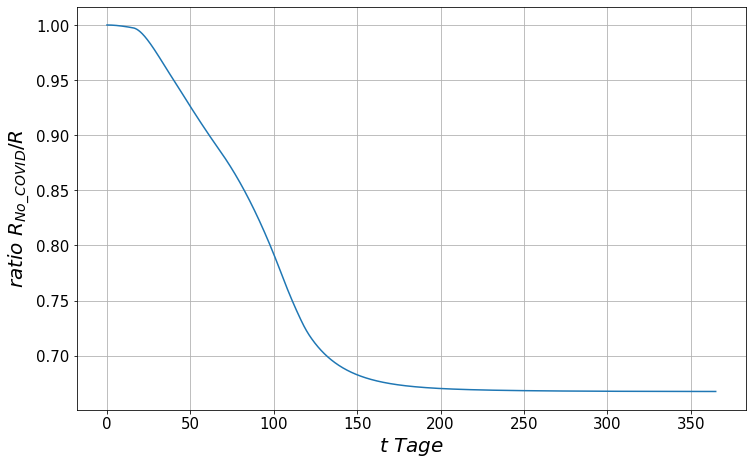

In [19]:
   
size=12
plt.figure(figsize=(size,size*0.618))
plt.plot(t,y)
plt.ylabel("$ratio\ R_{No\_COVID}/R$", fontsize=20)
plt.xlabel("$t\ Tage$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.legend(fontsize = 15)
plt.grid(True)
plt.show()